In [2]:
!nvidia-smi

Tue May 21 07:24:34 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    15W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import numpy as np
import os
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.mobilenet import preprocess_input
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPool2D
!pip install kaggle
!pip install livelossplot
from livelossplot.keras import PlotLossesCallback
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [14]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 1.15G/1.15G [00:10<00:00, 112MB/s] 
100% 1.15G/1.15G [00:10<00:00, 115MB/s]


In [18]:
#Importing of training photos of the data set

train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input, horizontal_flip=True, vertical_flip=True)
train_generator=train_datagen.flow_from_directory(
    './chest_xray/train/',
    target_size=(224,224),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

Found 5216 images belonging to 2 classes.


In [19]:
#Importing of validation photos of the data set
val_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
validation_generator=val_datagen.flow_from_directory(
    './chest_xray/val/',
    target_size=(224,224),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

Found 16 images belonging to 2 classes.


In [0]:
def plot_images(item_dir, top=25):
  all_item_dirs = os.listdir(item_dir)
  item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:top]

  plt.figure(figsize = (15,15))
  for idx, img_path in enumerate(item_files):
    plt.subplot(5,5, idx+1)
    img = mpimg.imread(img_path)
    plt.imshow(img)
  plt.tight_layout()

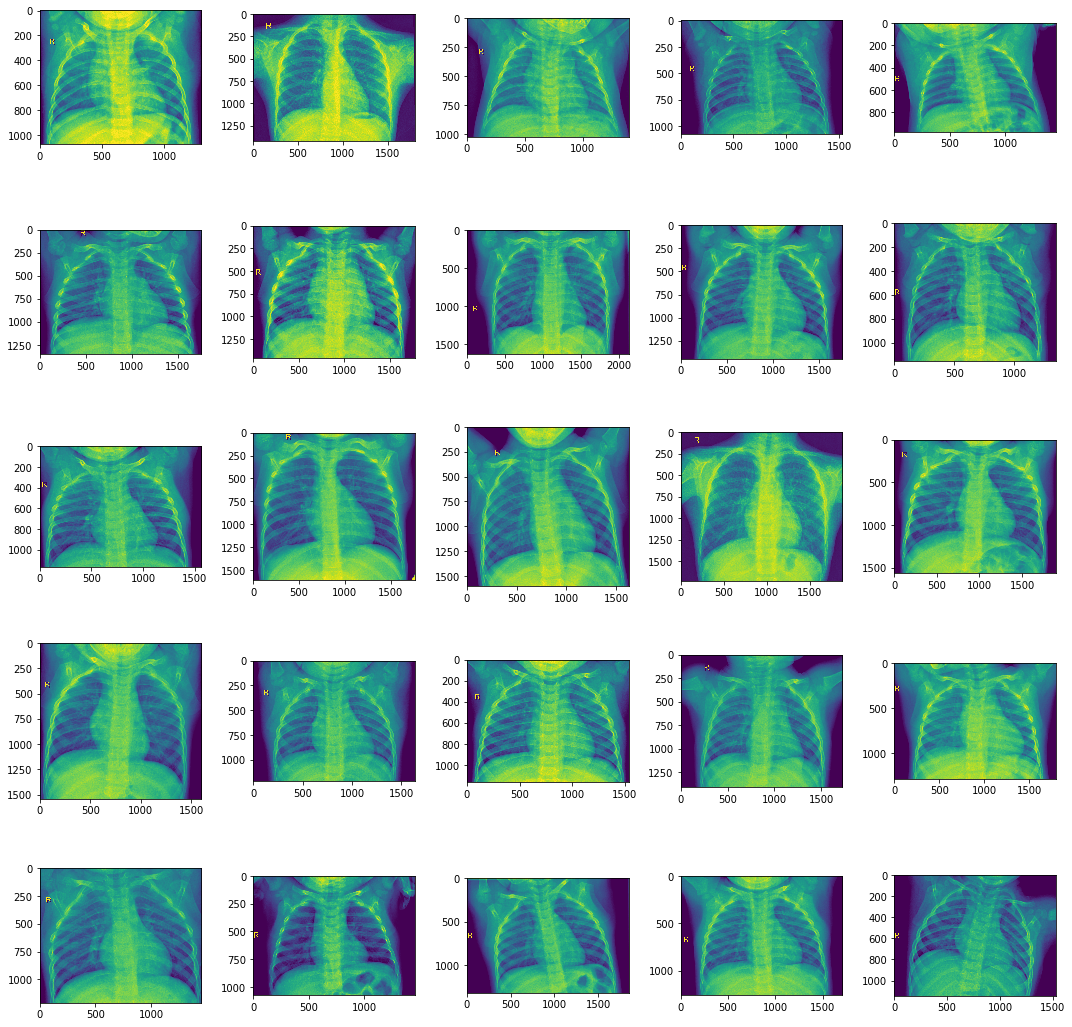

In [26]:
plot_images("./chest_xray/train/NORMAL/")

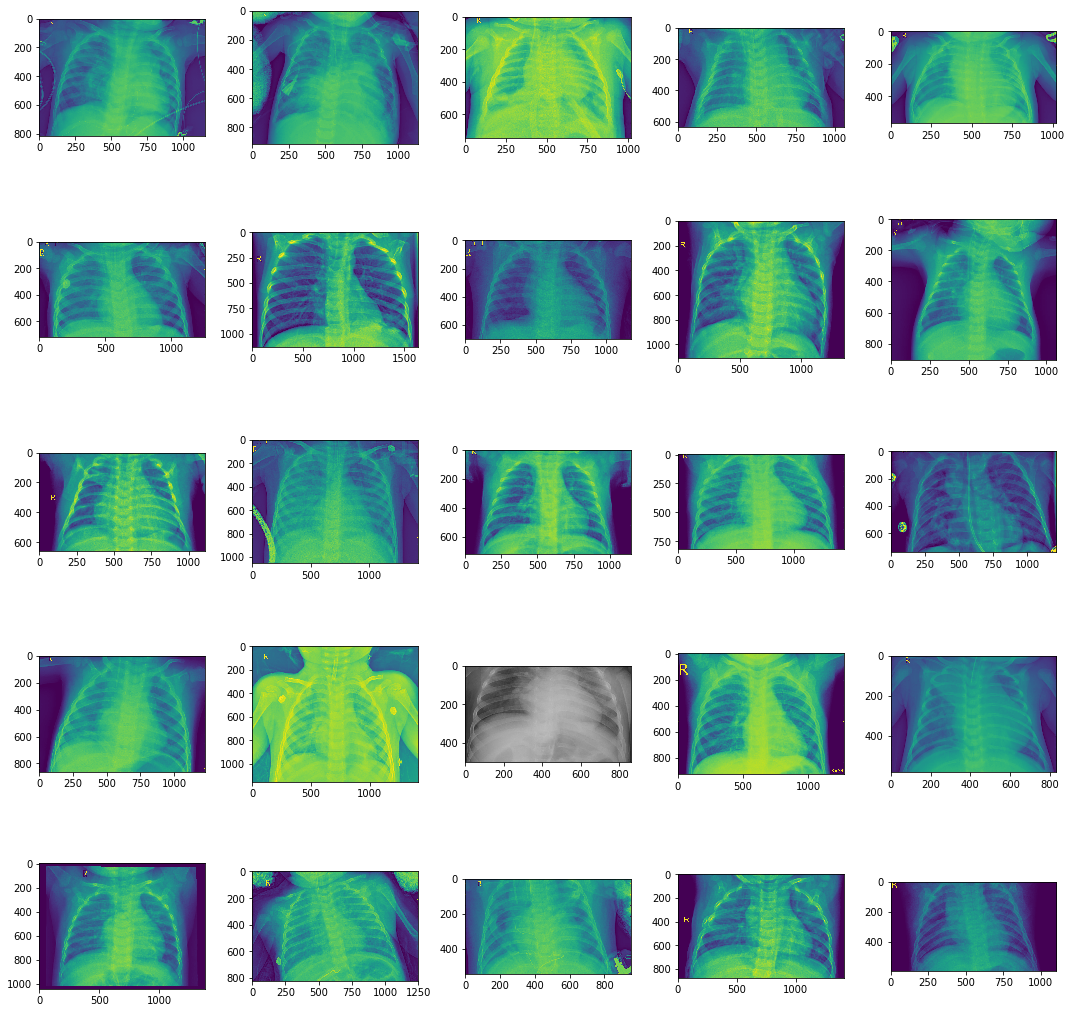

In [27]:
plot_images("./chest_xray/train/PNEUMONIA/")

In [34]:
input_shape = (224,224,1)

def myModel(input_shape):
   model = Sequential ([
    Conv2D(128, (3,3), input_shape=input_shape),
    MaxPool2D((2,2)),
    
    Conv2D(32, (3,3), activation='relu'),
    MaxPool2D((2,2)),
    
    #Conv2D(32, (3,3), activation='relu'),   
    #MaxPool2D((2,2)),
    
    Flatten(),

    Dense(512, activation='relu'),
       
    Dropout(0.5),
       
    Dense(128, activation='relu'),
       
    Dropout(0.5),
       
    Dense(2, activation='sigmoid')   
]) 
   return model


model = myModel(input_shape)

#Model Compilation
model.compile(
        loss='binary_crossentropy', 
        optimizer='rmsprop', 
        metrics=['accuracy']
)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 222, 222, 128)     1280      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 111, 111, 128)     0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 109, 109, 32)      36896     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 93312)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               47776256  
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
__________

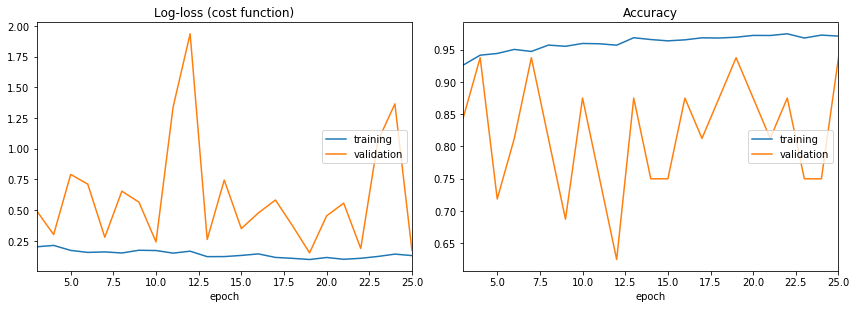

Log-loss (cost function):
training   (min:    0.097, max:    0.687, cur:    0.130)
validation (min:    0.152, max:    1.938, cur:    0.172)

Accuracy:
training   (min:    0.795, max:    0.975, cur:    0.971)
validation (min:    0.625, max:    0.938, cur:    0.938)


In [35]:
#Model training
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=25,
      validation_data=validation_generator,
      validation_steps=len(validation_generator),
      verbose=1,
      callbacks=[PlotLossesCallback()]
)

In [36]:
#Definition of the outputs
print(train_generator.class_indices)

{'NORMAL': 0, 'PNEUMONIA': 1}


In [0]:
model.save('pneumoniamodel.h5')

In [0]:
#Test X-Ray Import
#from tkinter import *
#from tkinter.filedialog import askopenfilename

#root = Tk()
#root.update()
#filename = askopenfilename()
#root.destroy()

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


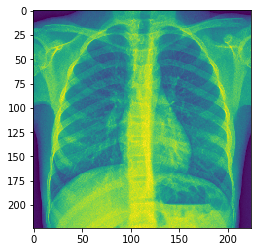

[[0.9357587  0.06478158]]
NORMAL


In [43]:
#Test Prediction
original = load_img('/content/chest_xray/test/NORMAL/IM-0033-0001-0002.jpeg', target_size=(224, 224), grayscale=True)
plt.imshow(original)
plt.show()
 
numpy_image = img_to_array(original)
image_batch = np.expand_dims(numpy_image, axis=0)



processed_image = preprocess_input(image_batch.copy())
predictions = model.predict(processed_image)

result = np.argmax(predictions)
print(predictions)

if result == 0:
    print("NORMAL")
elif result == 1:
    print("PNEUMONIA")